# Retirement Planner

---

## Environment Setup

In [15]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [3]:
# !pip install alpaca-trade-api

In [16]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [17]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [18]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [19]:
# Display sample data
df.head()

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [20]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()
daily_returns.dropna(inplace = True)  

# Display sample data
daily_returns.tail()

,AGG,SPY
,close,close
2019-12-24 00:00:00-05:00,0.001292,0.000125
2019-12-26 00:00:00-05:00,0.000934,0.005136
2019-12-27 00:00:00-05:00,0.001245,-0.000155
2019-12-30 00:00:00-05:00,0.000089,-0.005451
2019-12-31 00:00:00-05:00,-0.002308,0.002554


In [21]:
# Compute daily volatility
sharpe_ratios = (daily_returns.mean() * 1) / (daily_returns.std() * np.sqrt(1))
sharpe_ratios

AGG  close    0.101813
SPY  close    0.133007
dtype: float64

In [99]:
# Save the last day's closing price
AGG_close = df['AGG']['close'][-1]
SPY_close = df['SPY']['close'][-1]
SPY_close

321.92

In [100]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30

In [120]:
# Run the Monte Carlo Simulation
# monte_carlo = pd.DataFrame()
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation 
for n in range(number_simulations):
    simulated_agg_prices = [AGG_close]
    simulated_spy_prices = [SPY_close]
    
    # Simulate the returns for 252 * 30
    for i in range(number_records):
        # Calculate the simulated price using the last price within the list
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        # Append the simulated price to the list
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
        
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% AGG; 40% SPY)
    weights = [0.60, 0.40]
    
    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

In [121]:
# Check that the simulation ran successfully
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003749,0.995620,1.004993,1.000301,0.999137,0.999208,1.005161,0.998293,1.001933,1.000210,...,0.997003,0.999980,1.001083,1.001221,0.997271,1.009310,0.997177,1.005395,1.003307,0.999532
2,1.005537,0.996239,1.005872,1.003238,0.995206,0.995280,1.008506,0.999766,1.001562,1.002054,...,1.001817,0.999811,0.998829,0.998661,1.001448,1.006876,0.997782,1.009118,1.008563,0.996244
3,1.005039,0.996926,1.006475,1.005791,0.995161,0.995149,1.005267,1.006102,0.997419,1.001363,...,1.006169,1.000244,0.997670,0.999679,1.002143,1.004939,0.999027,1.011937,1.012619,0.993670
4,1.008438,0.992701,1.004768,1.001305,0.993925,0.991253,1.003775,1.005549,0.996694,0.992568,...,1.010627,0.996583,0.994363,0.997866,0.999208,1.006680,1.003600,1.014565,1.009348,0.991436


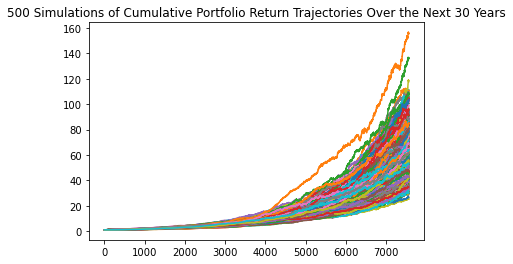

In [122]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title);

In [123]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
index = (252 * 20) - 1

portfolio_cumulative_returns.iloc[index, :]

0      20.090457
1      11.485579
2      15.866507
3      19.469538
4      17.634752
         ...    
495    13.561449
496    15.028217
497    19.190261
498    15.339346
499    17.267225
Name: 5039, Length: 500, dtype: float64

In [132]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns_20yrs = portfolio_cumulative_returns.iloc[index, :]
ending_cumulative_returns_20yrs.head()

0    20.090457
1    11.485579
2    15.866507
3    19.469538
4    17.634752
Name: 5039, dtype: float64

In [133]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns_20yrs.quantile(q=[0.05, 0.95])
confidence_interval

0.05     9.938529
0.95    22.851546
Name: 5039, dtype: float64

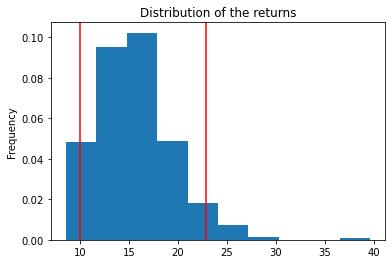

<Figure size 432x288 with 0 Axes>

In [134]:
# Visualize the distribution of the ending returns
ending_cumulative_returns_20yrs.plot(kind='hist', density=True, bins=10)

plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')
plt.title('Distribution of the returns')
plt.figure();

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [149]:
# Compute cumulative returns
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]

# Compute expected portfolio return (10th percentiles)
confidence_interval_10th = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval_10th

# Compute expected portfolio return (50th percentiles)
confidence_interval_50th = ending_cumulative_returns.quantile(q=[0.25, 0.25])
confidence_interval_50th

# Compute expected portfolio return (90th percentiles)
confidence_interval_90th = ending_cumulative_returns.quantile(q=[0.45, 0.45])
confidence_interval_90th

0.45    57.030221
0.45    57.030221
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [152]:
def compute_expected_portfolio_return(investment, lower, upper):
    confidence_interval = ending_cumulative_returns.quantile(q=[lower, upper])
    investment_lower_bound = investment + (investment * confidence_interval.iloc[0])
    investment_upper_bound = investment + (investment * confidence_interval.iloc[1])
    return investment_lower_bound, investment_upper_bound 

# Set initial investment
initial_investment = 20000

# Compute expected portfolio return (90th percentiles)
investment_pnl_lower_bound, investment_pnl_upper_bound = compute_expected_portfolio_return(initial_investment, 0.05, 0.95)

print(f"There is a 90% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

# Compute expected portfolio return (50th percentiles)
investment_pnl_lower_bound, investment_pnl_upper_bound = compute_expected_portfolio_return(initial_investment, 0.25, 0.25)

print(f"There is a 50% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")


# Compute expected portfolio return (10th percentiles)
investment_pnl_lower_bound, investment_pnl_upper_bound = compute_expected_portfolio_return(initial_investment, 0.45, 0.45)

print(f"There is a 10% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 90% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $712643.513034772 and $1920318.5043531945
There is a 50% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $969519.1137093751 and $969519.1137093751
There is a 10% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $1160604.419301966 and $1160604.419301966


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [157]:
# Set Plaid's projected income
projected_yearly_income = 6085

# Calculate the 4% withdrawal for the ending return as retirement income
investment_pnl_lower_bound, investment_pnl_upper_bound = compute_expected_portfolio_return(initial_investment, 0.45, 0.45)

retirement_income_1st = (0.04 * investment_pnl_lower_bound)

# Determine if the retirement income meets or exceeds the current projected income
if (retirement_income_1st < projected_yearly_income):
    print(f"The retirement income of ${retirement_income_1st} did not meet or exceed the projected income of ${projected_yearly_income}.")
else:
    print(f"The retirement income of ${retirement_income_1st} did meet and/or exceed the projected income of ${projected_yearly_income}.")      

The retirement income of $46424.17677207864 did meet and/or exceed the projected income of $6085.


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [158]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
investment_increase = 1.50 * initial_investment
investment_increase_lower_bound, investment_increase_upper_bound = compute_expected_portfolio_return(investment_increase, 0.45, 0.45)

retirement_income_2nd = (0.04 * investment_increase_lower_bound)

# Determine if the retirement income meets or exceeds the current projected income
if (retirement_income_2nd < projected_yearly_income):
    print(f"The retirement income of ${retirement_income_2nd} did not meet or exceed the projected income of ${projected_yearly_income}.")
else:
    print(f"The retirement income of ${retirement_income_2nd} did meet and/or exceed the projected income of ${projected_yearly_income}.")      

The retirement income of $69636.26515811795 did meet and/or exceed the projected income of $6085.


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [166]:
# Compute projected returns

# Display sample data


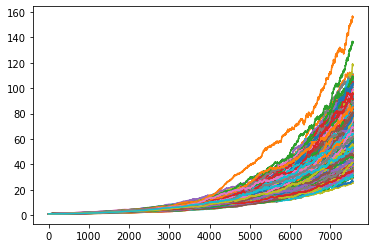

In [168]:
# Plot the cumulative returns over time
# portfolio_cumulative_returns.plot(legend=False)

In [ ]:
# Compute portfolio performance over time

# Plot projected performance over time
